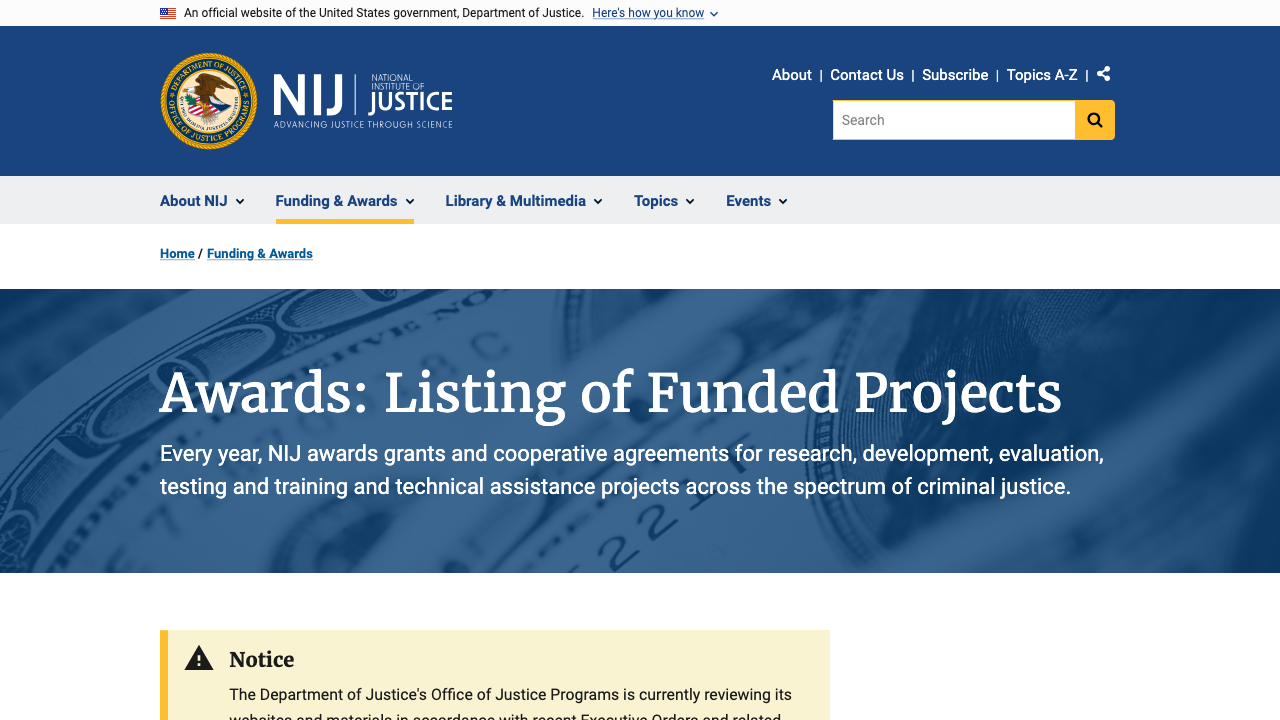

In [4]:
from playwright.async_api import async_playwright
import nest_asyncio
import asyncio
from bs4 import BeautifulSoup
import pandas as pd
from IPython.display import display, Image

nest_asyncio.apply()  # allows nested event loops in Jupyter

# Launch Playwright and keep the browser open
async def launch_browser():
    p = await async_playwright().start()
    browser = await p.firefox.launch(headless=False)
    context = await browser.new_context()
    page = await context.new_page()
    await page.goto("https://nij.ojp.gov/funding/awards/list")  # normal load
    screenshot_bytes = await page.screenshot()
    display(Image(screenshot_bytes))
    return p, browser, page  # return playwright object too

# Run in Jupyter
p, browser, page = await launch_browser()


In [ ]:
#scraping a single page
# Get page content and parse with BeautifulSoup
html = await page.content()
soup = BeautifulSoup(html, "html.parser")

# Find all table rows (excluding the header)
table_rows = soup.select("table.views-table tbody tr")

# Extract data from each row
data = []
for row in table_rows:
    cols = row.find_all("td")
    row_data = {
        "Fiscal Year": cols[0].get_text(strip=True),
        "Title": cols[1].get_text(strip=True),
        "Title Link": "https://nij.ojp.gov" + cols[1].find("a")["href"] if cols[1].find("a") else "",
        "Original Solicitation": cols[2].get_text(strip=True),
        "Recipient": cols[3].get_text(strip=True),
        "State": cols[4].get_text(strip=True),
        "Award Number": cols[5].get_text(strip=True),
        "Amount": cols[6].get_text(strip=True),
        "Status": cols[7].get_text(strip=True),
    }
    data.append(row_data)

# Convert to DataFrame and preview
df = pd.DataFrame(data)
df.head()


,Fiscal Year,Title,Title Link,Original Solicitation,Recipient,State,Award Number,Amount,Status
0,2024,A Combined Molecular Analysis of Pollen Utiliz...,https://nij.ojp.gov/funding/awards/15pnij-24-g...,NIJ FY24 Graduate Research Fellowship,THE UNIVERSITY OF CENTRAL FLORIDA BOARD OF TRU...,FL,15PNIJ-24-GG-01571-RESS,"$120,000",Open
1,2024,A Comparative Evaluation of the MinION and MiS...,https://nij.ojp.gov/funding/awards/15pnij-24-g...,NIJ FY24 Research and Development in Forensic ...,FLORIDA INTERNATIONAL UNIVERSITY,FL,15PNIJ-24-GG-03842-SLFO,"$487,790",Open
2,2024,A Comprehensive Evaluation and Error Rate Asse...,https://nij.ojp.gov/funding/awards/15pnij-24-g...,NIJ FY24 Research and Development in Forensic ...,RESEARCH TRIANGLE INSTITUTE,NC,15PNIJ-24-GG-03851-SLFO,"$499,902",Open
3,2024,A Focused Deterrence Program for Juveniles wit...,https://nij.ojp.gov/funding/awards/15pnij-24-g...,NIJ FY24 Research and Evaluation on Youth Just...,FLORIDA STATE UNIVERSITY,FL,15PNIJ-24-GG-03092-MUMU,"$1,255,241",Open
4,2024,A Multi-District Analysis of School Safety in ...,https://nij.ojp.gov/funding/awards/15pnij-24-g...,NIJ FY24 Research and Evaluation on School Safety,RESEARCH TRIANGLE INSTITUTE,NC,15PNIJ-24-GK-01051-STOP,"$933,524",Open


In [6]:
# Save DataFrame to CSV
df.to_csv("nij_awards.csv", index=False)


In [ ]:
#scraping all 10 pages

from tqdm.notebook import tqdm
import time

all_data = []

for page_num in tqdm(range(10), desc="Scraping pages"):
    # Get page content
    html = await page.content()
    soup = BeautifulSoup(html, "html.parser")
    
    # Extract table rows
    table_rows = soup.select("table.views-table tbody tr")
    for row in table_rows:
        cols = row.find_all("td")
        row_data = {
            "Fiscal Year": cols[0].get_text(strip=True),
            "Title": cols[1].get_text(strip=True),
            "Title Link": "https://nij.ojp.gov" + cols[1].find("a")["href"] if cols[1].find("a") else "",
            "Original Solicitation": cols[2].get_text(strip=True),
            "Recipient": cols[3].get_text(strip=True),
            "State": cols[4].get_text(strip=True),
            "Award Number": cols[5].get_text(strip=True),
            "Amount": cols[6].get_text(strip=True),
            "Status": cols[7].get_text(strip=True),
        }
        all_data.append(row_data)
    
    # Click "Next" if not on the last page
    if page_num < 9:
        next_button = await page.query_selector("span.usa-pagination__link-text:text('Next ›')")
        if next_button:
            await next_button.click()
            await page.wait_for_timeout(2000)  # wait 2 seconds for page to load
        else:
            print("Next button not found, stopping early.")
            break

# Convert to DataFrame
df_all = pd.DataFrame(all_data)

# Preview first few rows
df_all.head()

# Save to CSV
df_all.to_csv("nij_awards_10pages.csv", index=False)
print("Saved to nij_awards_10pages.csv")


Scraping pages:   0%|          | 0/10 [00:00<?, ?it/s]

Saved to nij_awards_10pages.csv


In [9]:
df_all.head()

,Fiscal Year,Title,Title Link,Original Solicitation,Recipient,State,Award Number,Amount,Status
0,2024,A Combined Molecular Analysis of Pollen Utiliz...,https://nij.ojp.gov/funding/awards/15pnij-24-g...,NIJ FY24 Graduate Research Fellowship,THE UNIVERSITY OF CENTRAL FLORIDA BOARD OF TRU...,FL,15PNIJ-24-GG-01571-RESS,"$120,000",Open
1,2024,A Comparative Evaluation of the MinION and MiS...,https://nij.ojp.gov/funding/awards/15pnij-24-g...,NIJ FY24 Research and Development in Forensic ...,FLORIDA INTERNATIONAL UNIVERSITY,FL,15PNIJ-24-GG-03842-SLFO,"$487,790",Open
2,2024,A Comprehensive Evaluation and Error Rate Asse...,https://nij.ojp.gov/funding/awards/15pnij-24-g...,NIJ FY24 Research and Development in Forensic ...,RESEARCH TRIANGLE INSTITUTE,NC,15PNIJ-24-GG-03851-SLFO,"$499,902",Open
3,2024,A Focused Deterrence Program for Juveniles wit...,https://nij.ojp.gov/funding/awards/15pnij-24-g...,NIJ FY24 Research and Evaluation on Youth Just...,FLORIDA STATE UNIVERSITY,FL,15PNIJ-24-GG-03092-MUMU,"$1,255,241",Open
4,2024,A Multi-District Analysis of School Safety in ...,https://nij.ojp.gov/funding/awards/15pnij-24-g...,NIJ FY24 Research and Evaluation on School Safety,RESEARCH TRIANGLE INSTITUTE,NC,15PNIJ-24-GK-01051-STOP,"$933,524",Open
